# Image labeller with persistence (example)

This notebook will demonstrate the follwing:

- using the image labelling tool as an IPython Notebook plugin
- rendering labels to create edge maps and label images
- extracting images of individual objects

It will also describe the label JSON file format.

In [1]:
%matplotlib inline

import math

from matplotlib import pyplot as plt

from IPython.display import display, Javascript

from image_labelling_tool import labelling_tool, labelling_tool_jupyter

/Users/Geoff/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Geoff/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


## Client side widget

Here is the client side widget implementation:

In [2]:
display(Javascript(labelling_tool_jupyter.LABELLING_TOOL_JUPYTER_JS))

<IPython.core.display.Javascript object>

## Example tool

The kernel-side widget model is defined in the `ImageLabellingTool` class in the `labelling_tool` module.

**Note**: the 'Loading...' screen may persist for a while initially; this is because the client-side tool is waiting for the notebook to finish executing all the cells below so it can get round to sending the label data to the client.

In [3]:
# Specify our 3 label classes.
# `LabelClass` parameters are: symbolic name, human readable name for UI, and RGB colour as list
label_classes = [labelling_tool.LabelClass('tree', 'Trees', [0, 255, 192]),
                 labelling_tool.LabelClass('building', 'Buldings', [255, 128, 0]),
                 labelling_tool.LabelClass('lake', 'Lake', [0, 128, 255]),
                 ]

# Define the tool dimensions
TOOL_WIDTH, TOOL_HEIGHT = 980, 480

# Load in .JPG images from the 'images' directory.
labelled_images = labelling_tool.PersistentLabelledImage.for_directory('images', image_filename_pattern='*.jpg')
print 'Loaded {0} images'.format(len(labelled_images))

labelling_tool_config = {
    'tools': {
        'imageSelector': True,
        'labelClassSelector': True,
        'drawPolyLabel': True,
        'compositeLabel': True,
        'deleteLabel': True
    }
}

# Create the labelling tool IPython widget and display it
labeller = labelling_tool_jupyter.ImageLabellingTool(labelled_images=labelled_images, label_classes=label_classes,
                                                     tool_width=TOOL_WIDTH, tool_height=TOOL_HEIGHT,
                                                    labelling_tool_config=labelling_tool_config)

display(labeller)

Loaded 2 images


### Instructions for use

To navigate between images:

- Using the left and right arrows to navigate the images one by one
- Enter a number in the box at the top to navigate to a specific image

To move around images:

- Left-click drag to move the image
- Use the scroll wheel (on a mouse) or a two-finger gesture (on a tablet) to zoom

To label regions of the image:

- **Drawing regions onto the image:**
  - Click the *Draw poly* button
  - Within the image pane, left-click to draw polygonal corners of your region
  - When you have finished the region, right-click to stop
  - You are still in *draw poly* mode, so you can start left-clicking again to draw the next region
  - To exit *draw poly* mode, right-click a second time.
  - If you make a mistake, delete the region and re-draw it; see below
- **Selecting regions:**
  - Selected regions have a red outline, yellow otherwise
  - If only *one* region is selected, clicking the *Draw poly* button will allow you to modify it; you will go back to *draw poly* mode
  - To select a different region, click the *Select* button and choose a different region by clicking on it. Multiple regions can be selected by holding *SHIFT* while clicking.
- **Deleting regions:**
  - Select regions using the select tool (see above)
  - Click the wastebin button to delete them; you will be asked for confirmation
- **Changing the label of a region:**
  - Select regions using the select tool (see above)
  - Use the drop-down (normally reads *UNCLASSIFIED*) within the *Labels* section to change the label
- **If the coloured regions are obscuring parts of the image that you need to see:**
  - Within the *Labels* section, click the *Hide labels* checkbox to hide the labels
  - Uncheck it to show them afterwards
- **When you are done:**
  - When you are satisfied that you have marked out all of the regions of interest and that they are correctly labelled, click the *Finished* checkbox within the *Current image* section. This will mark the image as finished within the system.

## Using the label data

You can either render the labels with the provided code or read the JSON label data directly.

### Render the labels

First, get the second image that comes with some labels pre-defined:

In [4]:
labelled_img = labelled_images[1]

#### Rendering label masks by label class

As seen in the *Example Tool* cell above we have three classes; `tree`, `building` and `lake`.

The `label_classes` parameter describes the classes to render. For example, lets render all the labels trees:

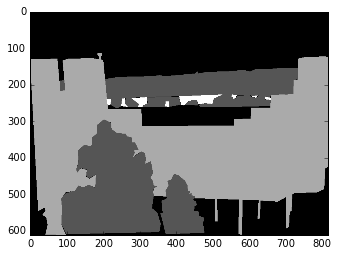

In [5]:
labels_2d = labelled_img.render_labels(label_classes=['tree', 'building', 'lake'], pixels_as_vectors=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Re-ordering changes the label values:

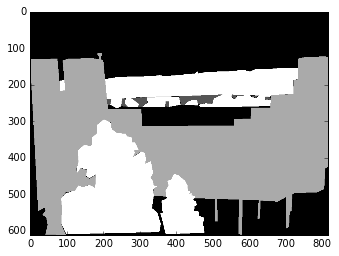

In [6]:
labels_2d = labelled_img.render_labels(label_classes=['lake', 'building', 'tree'], pixels_as_vectors=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

You can render a subset of the labels used in the image; just the trees:

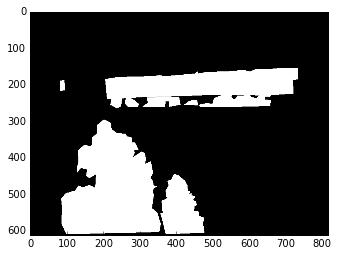

In [7]:
labels_2d = labelled_img.render_labels(['tree'], pixels_as_vectors=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Each item in `label_classes` can also be a list of classes. This will result in the same value being used for multiple classes in the image. Lets render the natural featues - lake and trees - as one value and the non-natural - buildings - as another:

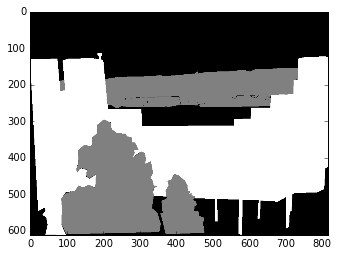

In [8]:
labels_2d = labelled_img.render_labels(label_classes=[['tree', 'lake'], 'building'], pixels_as_vectors=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Setting the `fill` parameter to `False` results in outlines being rendered:

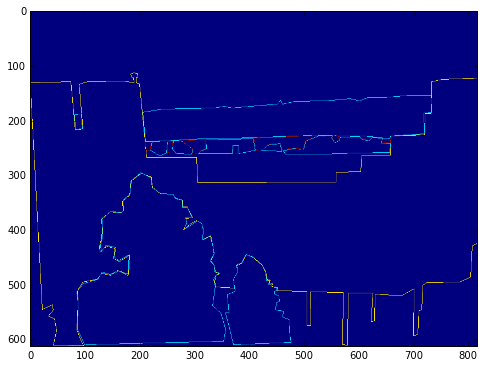

In [9]:
labels_2d = labelled_img.render_labels(label_classes=['tree', 'building', 'lake'], pixels_as_vectors=False, fill=False)
plt.figure(figsize=(8,6))
plt.imshow(labels_2d)
plt.show()

Setting the `pixels_as_vectors` parameter to `True` will result in a multi-channel image in the form of a 3D array. It will have one channel for each item in `label_classes`. Pixels will have either a value of `0` or `1` in a given channel indicating presence of a label in that class:

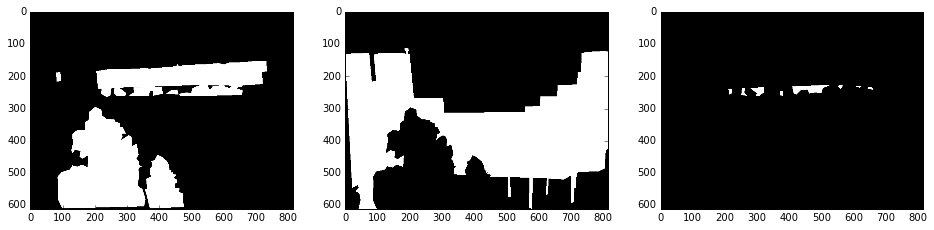

In [10]:
labels_2dn = labelled_img.render_labels(label_classes=['tree', 'building', 'lake'], pixels_as_vectors=True)
plt.figure(figsize=(16,4))
# trees
plt.subplot(1,3,1)
plt.imshow(labels_2dn[:,:,0], cmap='gray')
# buildings
plt.subplot(1,3,2)
plt.imshow(labels_2dn[:,:,1], cmap='gray')
# lake
plt.subplot(1,3,3)
plt.imshow(labels_2dn[:,:,2], cmap='gray')
plt.show()

#### Rendering label masks by individual label

The `render_individual_labels` method assigns a different label value to each individual object. It returns a multi-channel image as a 3D array and a the gives the number of labels in each channel. The `label_classes` parameter functions as with the `render_labels` method.

Label count=[9 1 8]


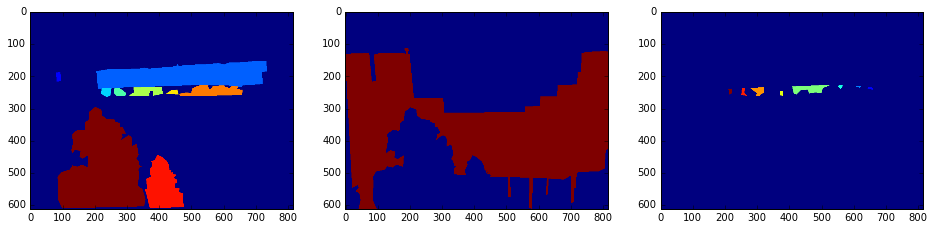

In [11]:
labels_2dn, label_count = labelled_img.render_individual_labels(label_classes=['tree', 'building', 'lake'])
print 'Label count={0}'.format(label_count)
plt.figure(figsize=(16,4))
# trees
plt.subplot(1,3,1)
plt.imshow(labels_2dn[:,:,0])
# buildings
plt.subplot(1,3,2)
plt.imshow(labels_2dn[:,:,1])
# lake
plt.subplot(1,3,3)
plt.imshow(labels_2dn[:,:,2])
plt.show()

Setting the `fill` parameter to `False` results in an outline image as before:

Label count=[9]


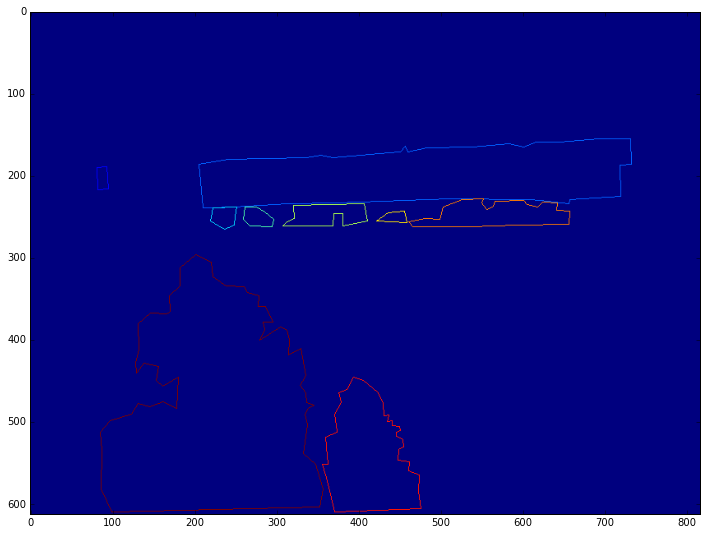

In [12]:
# Only render trees so that we can show one large image, otherwise the 1-pixel-wide outlines
# will be difficult to see:
labels_2dn, label_count = labelled_img.render_individual_labels(label_classes=['tree'],
                                                               fill=False)
print 'Label count={0}'.format(label_count)
plt.figure(figsize=(12,9))
plt.imshow(labels_2dn[:,:,0])
plt.show()

#### Extracting images of labelled objects

The `extract_label_images` method extracts the pixels covered by each individual labelled object from the original image. The `label_class_set` parameter specifies the classes of objects that should be rendered; objects whoses classes are not listed are not rendered. It can also be `None` to render all objects of all classes. It returns a list of images:

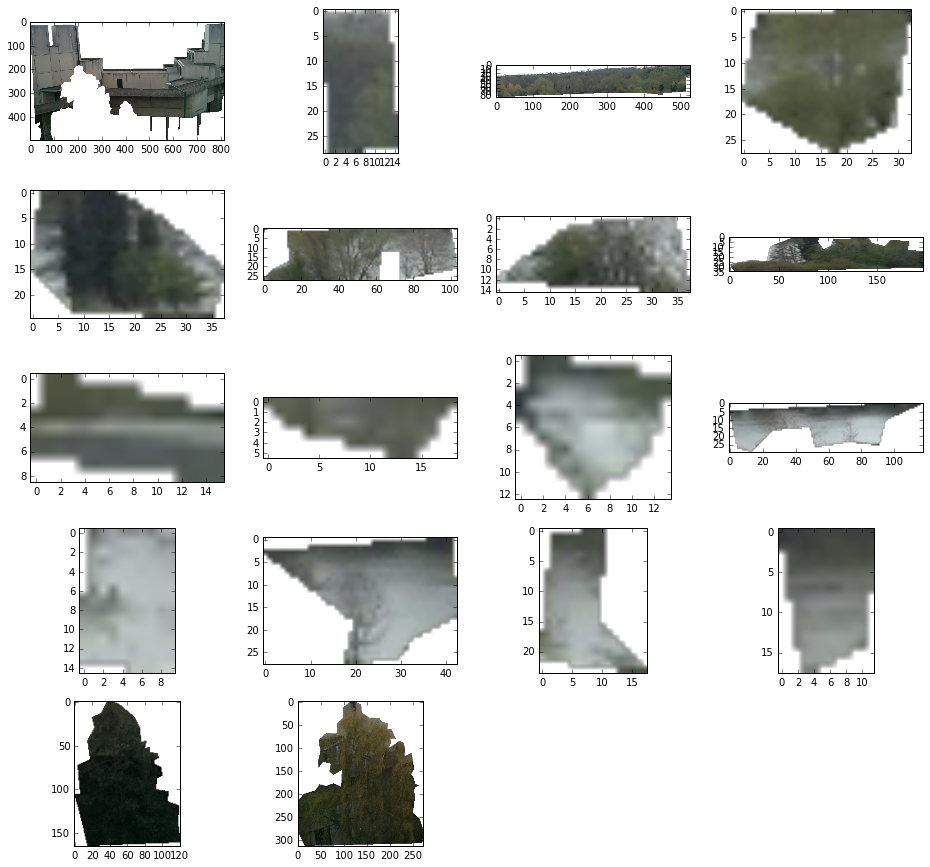

In [13]:
# Render all objects:
object_images = labelled_img.extract_label_images(label_class_set=None)
n_cols = 4
n_rows = int(math.ceil(float(len(object_images)) / n_cols))
plt.figure(figsize=(16,n_rows*3))
    
for i, img in enumerate(object_images):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
plt.show()

Extract objects separately by class:

Extracted objects of class 'tree':


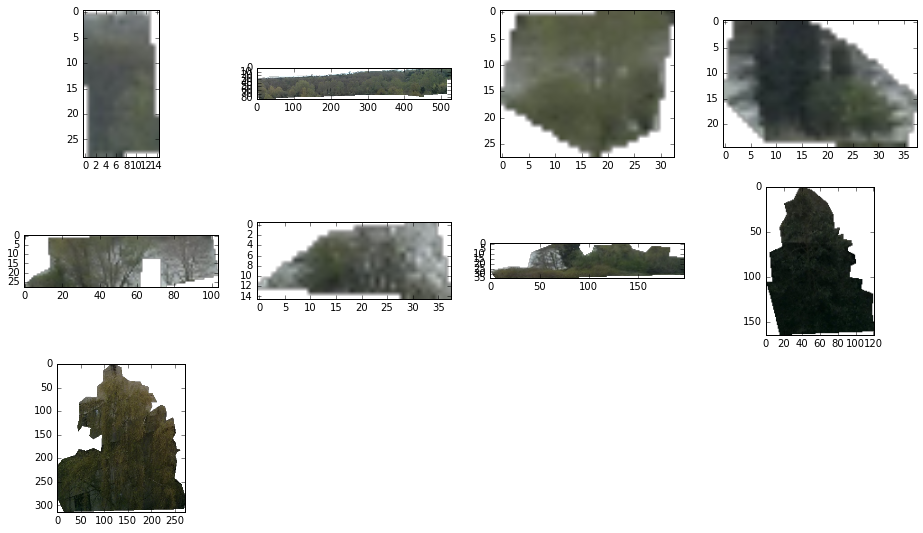

Extracted objects of class 'lake':


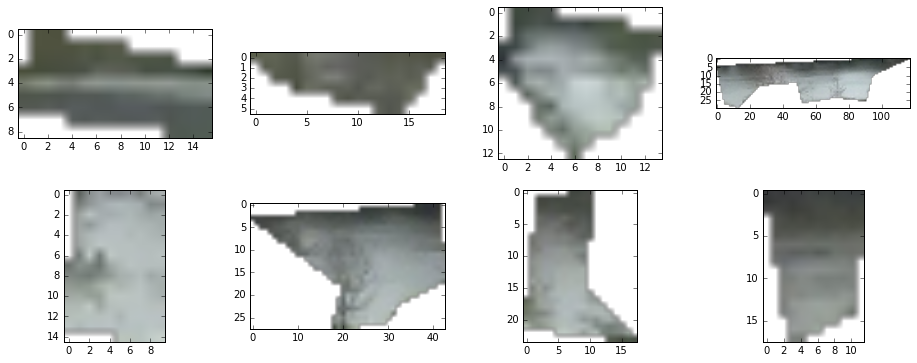

Extracted objects of class 'building':


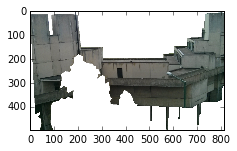

In [14]:
for cls in ['tree', 'lake', 'building']:
    print 'Extracted objects of class \'{0}\':'.format(cls)
    object_images = labelled_img.extract_label_images(label_class_set=[cls])
    n_cols = 4
    n_rows = int(math.ceil(float(len(object_images)) / n_cols))
    plt.figure(figsize=(16,n_rows*3))

    for i, img in enumerate(object_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
    plt.show()

### JSON Label Format

The label data is in JSON form. An example file is included in the `images` directory. The format of the file will now be described.

```
<root>: 

{
    image_filename: <image filename as string>
    labels: [
        <label_object 0>,
        <label_object 1>,
        ...
        <label_object N>
    ]
}


<label_object -- where label_type=polygon>:
{
    label_class: <label class as string; identifiers used above to identify label classes>
    label_type: 'polygon',
    vertices: [
        <vertex 0>,
        <vertex 1>,
        ...
        <vertex N>
    ]
}


<vertex>:
{
    x: <x-co-ordinate as float>,
    y: <y-co-ordinate as float>
}
```
